# Gradient verification for the 1D - non reactive transport (diffusion + advection), permeability inversion from head observations 

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
from pathlib import Path
import os
import logging
import copy
import time
from typing import Dict, Generator
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.utils import indices_to_node_number, node_number_to_indices
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np

import pandas as pd
import scipy as sp
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test



- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 9.3  # voxel dimension along the x axis
dy = 8.45  # voxel dimension along the y axis
duration_in_days = 6
duration_in_s = duration_in_days * 3600 * 24
dt_init = 6 * 3600  # timestep in seconds = 6h
dt_min = 2 * 3600
dt_max = 12 * 3600

c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s]
k0 = 1e-4  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1e-5  # molal
storage_coefficient = 1e-3
# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

In [7]:
crank_nicolson = 0.86  # enough to ensure stability and test "semi-implcit"
flow_regime = "transient"
is_gravity = True
cst_head_left = 100  # m
cst_head_right = 70  # m

- x_coordinates array for the plots

In [8]:
x_coordinates = (np.arange(nx) + 0.5) * dx

- Three observation wells

In [9]:
production_locations = [12, 28]
injection_locations = [4, 20, 36]

- Create an reference and an initial estimate distribution for the permebility

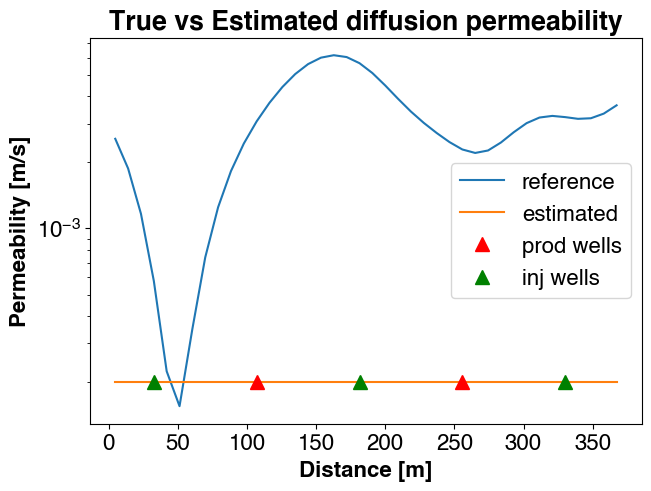

In [10]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 2e-4
max_val = 1e-2
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2.5
stdev = (max_val - min_val) / 3.0 / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 5.0

perm_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogeneous value
perm_estimate = np.ones((nx, ny)) * min_val  # m2/s

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Permeability [m/s]", fontweight="bold")
ax.set_yscale("log")
ax.set_title("True vs Estimated diffusion permeability", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, perm_reference, label="reference")
ax.plot(x_positions_in_meters, perm_estimate, label="estimated")

# Add some vertical lines to indicate the well
for well_pos in production_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="prod wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

for well_pos in injection_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="inj wells",
        marker="^",
        markersize=10,
        c="g",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "true_vs_estimated_initial_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The assays take place over 5 days: for each day, on well inject or pump at 6 m3/h, while the head is observed at the others

### Forward problem in demonstrator

In [11]:
# Simulation on 31 days. We use a 4h timestep.
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    is_gravity=is_gravity,
    crank_nicolson=crank_nicolson,
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params)

- Add boundary conditions and regional recharge

In [12]:
# Boundary conditions
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.head[0, :, :] = cst_head_left
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.head[-1, :, :] = cst_head_right

- Create the source terms for the pumping: one pumping test per day at -25 m3/h

In [13]:
day = 0
prod_flw = -8.0 / 3600  # 8 m3/h

nt_per_day = int(3600 * 24 / dt)

# two successive pumping on days 1 and 2
for loc in production_locations:
    day += 1
    sink_term = dmfwd.SourceTerm(
        "producer loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        # pumping on 1 day
        times=np.array((np.arange(nt_per_day) + 1 + day * nt_per_day) * time_params.dt),
        flowrates=np.array([prod_flw] * nt_per_day),
        concentrations=np.array([0.0] * nt_per_day),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

# three successive injections on days 3, 4 and 5
for i, loc in enumerate(injection_locations):
    day += 1
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        times=np.array((np.arange(nt_per_day) + 1 + day * nt_per_day) * time_params.dt),
        flowrates=np.array([-prod_flw] * nt_per_day),
        concentrations=np.array([0.0] * nt_per_day),
    )
    base_model.add_src_term(source_term)

NameError: name 'dt' is not defined

In [ ]:
source_term.times

array([453600, 475200, 496800, 518400])

- Check that the sources have been correctly defined: we plot the flowrate within time for the 30 wells: we see 30 intervals

In [ ]:
span = node_number_to_indices(np.arange(nx * ny), nx=nx, ny=ny)[:-1]
src = base_model.get_fl_sources()
plt.imshow(src[:, 0, :])

AttributeError: 'ForwardModel' object has no attribute 'get_fl_sources'

- Create two models with different permeabilities

In [ ]:
# copy the base model
model_reference = copy.deepcopy(base_model)
# update permeability
model_reference.fl_model.permeability = perm_reference
# solve the flow problem
dmfwd.ForwardSolver(model_reference).solve()

In [ ]:
# copy the base model
model_estimate = copy.deepcopy(base_model)
# update permeability
model_estimate.fl_model.permeability = perm_estimate
# solve the flow problem
dmfwd.ForwardSolver(model_estimate).solve()

### Forward problem definition in HYTEC

- Define a runner

In [ ]:
if runner_type == RunnerType.FRONTAL:
    runner = FrontalHytecRunner(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        nb_cpu=4,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.SLURM:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="geo-cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = SlurmHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.QSUB:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="Omines_cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = QsubHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
else:
    raise Exception("Could not created runner")

- Create an empty simulation in a non existing folder

In [ ]:
simu_base = HytecSimulation("simu_base", Path.cwd().joinpath("simu_base"))

- Add a TDB file

In [ ]:
simu_base.link_tdb("./../../../../../TDB/chess.tdb")  # This is relative to the htc file

- Define the output format

In [ ]:
simu_base.model.add_sub_item(hymd.OutputFormat("vtk"))

- Hydrodynamic model and its parameters definition


In [ ]:
if is_gravity:
    _flow_regime = flow_regime + ", density-flow"
else:
    _flow_regime = flow_regime

hmodel = hymd.HydrodynamicModel(
    hymd.FlowRegime(_flow_regime),
    hymd.Porosity(w0),
    hymd.Permeability(k0, units="m/s"),
    hymd.DiffusionCoefficient(D0, units="m2/s"),
    hymd.Head(0.0, "m"),
    hymd.FlowCrankNicolson(crank_nicolson),
)
simu_base.model.add_sub_item(hmodel)

- Geochemical unit definition

In [ ]:
chmodel = hymd.GeochemicalModel(hymd.Report("full"), hymd.Redox("disabled"))
# Define a geochem unit
base_unit = hymd.GeochemicalUnit("chem_base")
species = "T"
# Set concentrations
base_unit.add_sub_item(hymd.Concentration(species, 0.0, units="molal"))
# define tracer
chmodel.add_sub_item(hymd.Define("basis", species))

# exclude
chmodel.add_sub_item(hymd.Exclude(("minerals", "colloids", "gases")))

# Add the units to the geochemical model
chmodel.add_sub_item(base_unit)

# bypass the chemistry to get faster
chmodel.add_sub_item(hymd.ChemistryBypass("enabled"))

# Add to the main model
simu_base.model.add_sub_item(chmodel)

- Geometry definition

In [ ]:
gmodel = hymd.GeometryModel(
    hymd.GridRegime("rectangle"), hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny}")
)
zone_domain = hymd.Zone(
    "domain", hymd.Geometry("domain"), hymd.Geochemistry(base_unit.name)
)
gmodel.add_sub_item(zone_domain)
simu_base.model.add_sub_item(gmodel)

- Boundary model definition

In [ ]:
flc_right = hymd.FlowCondition(f"constant-head at {cst_head_right} m")
flc_left = hymd.FlowCondition(f"constant-head at {cst_head_left} m")
bmodel = hymd.BoundaryModel(
    hymd.Boundary(
        "border_left", hymd.Coordinates(f"0,0, 0,{ny*dy}", units="m"), flc_left
    ),
    hymd.Boundary(
        "border_right",
        hymd.Coordinates(f"{nx*dx},{ny*dy}, {nx*dx},0", units="m"),
        flc_right,
    ),
)
simu_base.model.add_sub_item(bmodel)

- Time discretization

In [ ]:
tmodel = hymd.TimeDiscretizationModel(
    hymd.Duration(duration_in_days * 3600 * 24, units="s"),
    hymd.TimeStep(
        hymd.Variable(
            hymd.StartValue(dt, "s"), hymd.Maximum(dt, "s"), hymd.CourantFactor(20.0)
        ),
    ),
)
simu_base.model.add_sub_item(tmodel)

- Sampling definition

In [ ]:
# Sampling model
smodel = hymd.SamplingModel(
    hymd.GridSampling(nt),
    hymd.Select("time", units="s"),
    hymd.Select("node-number"),
    hymd.Select("flowrate", units="m/s"),
    hymd.Select("permeability", units="m/s"),
    hymd.Select("head", units="m"),
    hymd.Select("porosity"),
    hymd.Select("diffusion"),
    hymd.Select("pressure"),
    hymd.Select("T", units="mol/kg"),
)
simu_base.model.add_sub_item(smodel)

- Create the injection/pumping file: 1 column per well + 1 column for the time (days)

In [ ]:
src_term_path: str = "MODIFY/source_terms.dat"
src_term_data: NDArrayFloat = np.zeros(
    (
        len(injection_locations) + len(production_locations) + 1,
        len(injection_locations) + len(production_locations) + 1,
    )
)
src_term_data[:, 0] = np.arange(stop=src_term_data.shape[0] + 1, start=1) - 0.2

- Create one zone per well with the correct flowrates: negative for producers and positive for injectors.

In [ ]:
# 1) Add the producer wells
count_prod: int = 0  # to avoid unbounded values in the next loop
for count_prod, ix in enumerate(production_locations):
    name = f"producer_{ix}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {(ix + 0.5) * dx},{0.5 * dy}, {dx},{dy}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    zone.add_sub_item(hymd.Source(0.0, units="m3/h", geochem_unit=base_unit.name))
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count_prod+2}",
                units="m3/h",
                geochem_unit=base_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="d",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)
    # Update the src_terms file -> 2 m3/h for a producer
    src_term_data[count_prod, count_prod + 1] = -8.0

n_prod_linked_list = [1, 2, 1]

count_inj = 0
# 2) Add the injector wells
for count_inj, ix in enumerate(injection_locations):
    name = f"injector_{ix}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {(ix + 0.5) * dx},{0.5 * dy}, {dx},{dy}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    zone.add_sub_item(hymd.Source(0.0, units="m3/h", geochem_unit=base_unit.name))
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count_prod + count_inj +3}",
                units="m3/h",
                geochem_unit=base_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="d",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)

    src_term_data[count_prod + count_inj + 1, count_prod + count_inj + 2] = 8.0

# 3) Add the src_data_file (need to write and read the file... which is a bit stupid...)
# Register the source data file
simu_base.register_modifiy_src_file(src_term_path, src_term_data, fmt="%.3f")

- Create two models from this base simulation

In [ ]:
simu_reference = copy.deepcopy(simu_base)
simu_reference.update_root_and_name(
    new_root="simu_reference", new_name="simu_reference"
)
simu_estimate = copy.deepcopy(simu_base)
simu_estimate.update_root_and_name(new_root="simu_estimate", new_name="simu_estimate")

- Add the diffusion fields to the simulations

In [ ]:
index: NDArrayFloat = np.arange(nx)

# True
data_true = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "porosity": 1.0,
        "permeability": 2e-3,  # perm_reference.ravel(),
    },  # need to flatten the parameter
    index=index,
)
simu_reference.add_param_file_data(ParameterFiles.HYDRO, data_true)

# Estimated
data_estimated = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "porosity": 1.0,
        "permeability": perm_estimate.ravel(),
    },  # need to flatten the parameter
    index=index,
)
simu_estimate.add_param_file_data(ParameterFiles.HYDRO, data_estimated)

- Checking the hydro parameters have been correctly set-up

In [ ]:
simu_reference.handlers.hydro.data

,node-number,x,porosity,permeability
0,0,4.65,1.0,0.002
1,1,13.95,1.0,0.002
2,2,23.25,1.0,0.002
3,3,32.55,1.0,0.002
4,4,41.85,1.0,0.002
5,5,51.15,1.0,0.002
6,6,60.45,1.0,0.002
7,7,69.75,1.0,0.002
8,8,79.05,1.0,0.002
9,9,88.35,1.0,0.002


In [ ]:
simu_estimate.handlers.hydro.data

,node-number,x,porosity,permeability
0,0,4.65,1.0,0.0002
1,1,13.95,1.0,0.0002
2,2,23.25,1.0,0.0002
3,3,32.55,1.0,0.0002
4,4,41.85,1.0,0.0002
5,5,51.15,1.0,0.0002
6,6,60.45,1.0,0.0002
7,7,69.75,1.0,0.0002
8,8,79.05,1.0,0.0002
9,9,88.35,1.0,0.0002


In [ ]:
simu_reference.handlers.modify_files.keys()

dict_keys([PosixPath('MODIFY/source_terms.dat')])

In [ ]:
simu_reference.write_input_files()
simu_estimate.write_input_files()
runner.run(simu_reference)
runner.run(simu_estimate)

INFO:root:The job is over ! Elapsed time = 0:00:00.304300
INFO:root:The job is over ! Elapsed time = 0:00:00.262724


True

### Comparison between hytec and the demonstrator for the forward problem

- Reading the results for the reference diffusion simulation

In [ ]:
simu_reference.read_hytec_results()
simu_reference.handlers.results.grid_res_columns

['timestep',
 'Zones',
 'time [s]',
 'node-number []',
 'flowrate [m/s]',
 'permeability [m/s]',
 'head [m]',
 'porosity []',
 'diffusion [m2/s]',
 'pressure [Pa]',
 'T [mol/kg]',
 'x-distance']

In [ ]:
head_ref_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="head [m]", nx=nx
)
pressure_ref_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="pressure [Pa]", nx=nx
)
perm_ref_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="permeability [m/s]", nx=nx
)
# Getting sample time. The unit is the same than the one defined for the simulation duration in the htc
grid_sample_times = simu_reference.handlers.results.get_sample_times_from_grid_res()

- Reading the results for the estimated diffusion simulation

In [ ]:
simu_estimate.read_hytec_results()
simu_estimate.handlers.results.grid_res_columns

['timestep',
 'Zones',
 'time [s]',
 'node-number []',
 'flowrate [m/s]',
 'permeability [m/s]',
 'head [m]',
 'porosity []',
 'diffusion [m2/s]',
 'pressure [Pa]',
 'T [mol/kg]',
 'x-distance']

In [ ]:
# Get the results on a 3D grid with the last dimension as time step
head_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="head [m]", nx=nx
)
perm_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="permeability [m/s]", nx=nx
)

- Top view

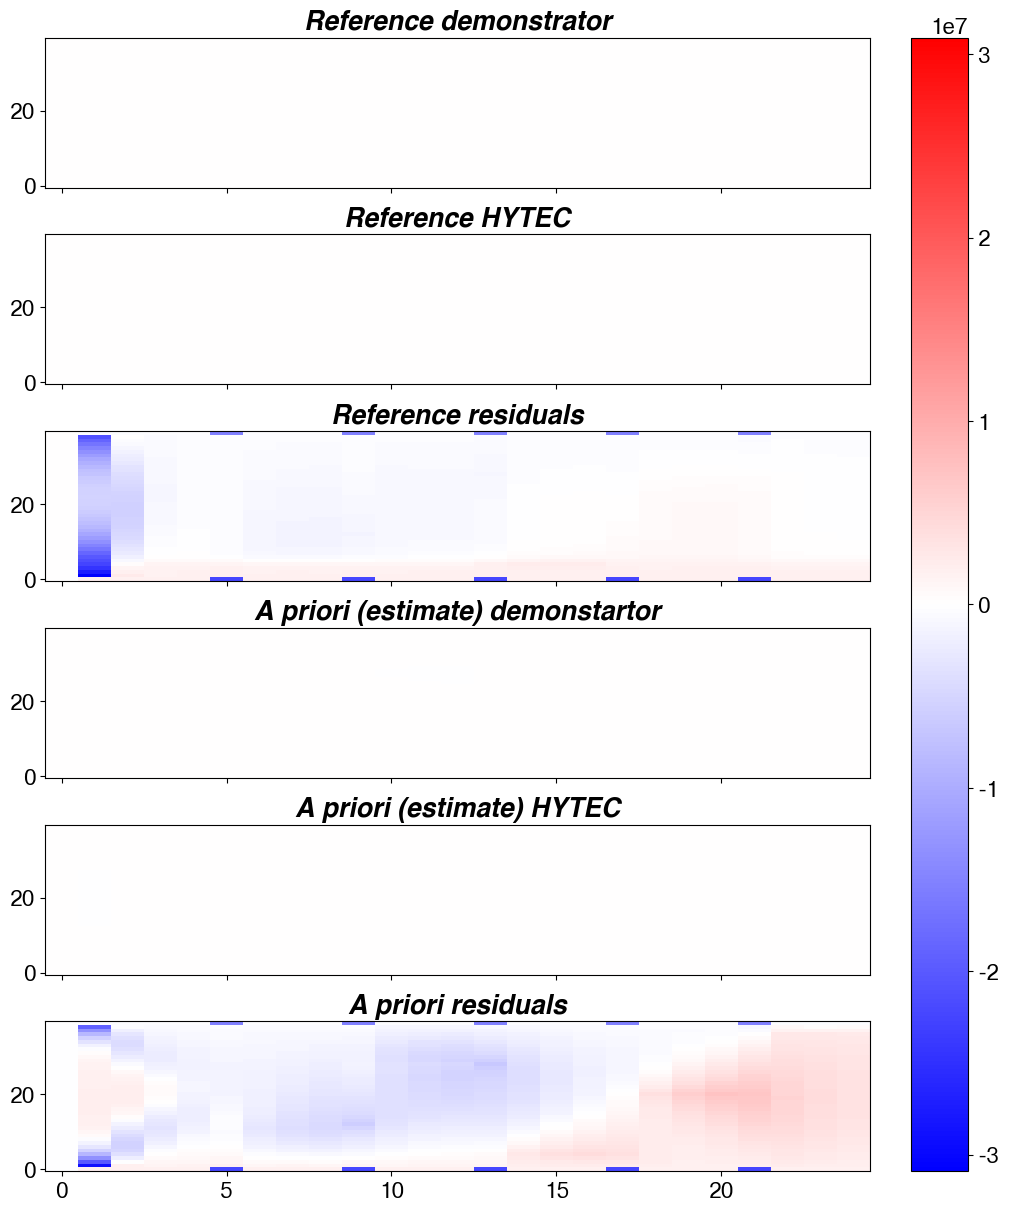

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"], ["ax6-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference demonstrator": model_reference.fl_model.head[:, 0, :].T,
        "Reference HYTEC": head_ref_hytec[:, 0, 0, :].T,
        "Reference residuals": (
            model_reference.fl_model.head[:, 0, :].T - head_ref_hytec[:, 0, 0, :].T
        )
        * 1e5,
        "A priori (estimate) demonstartor": model_estimate.fl_model.head[:, 0, :].T,
        "A priori (estimate) HYTEC": head_estimate_hytec[:, 0, 0, :].T,
        "A priori residuals": (
            model_estimate.fl_model.head[:, 0, :].T - head_estimate_hytec[:, 0, 0, :].T
        )
        * 1e5,
    },
    is_symmetric_cbar=True,
)

fname = "head_ref_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

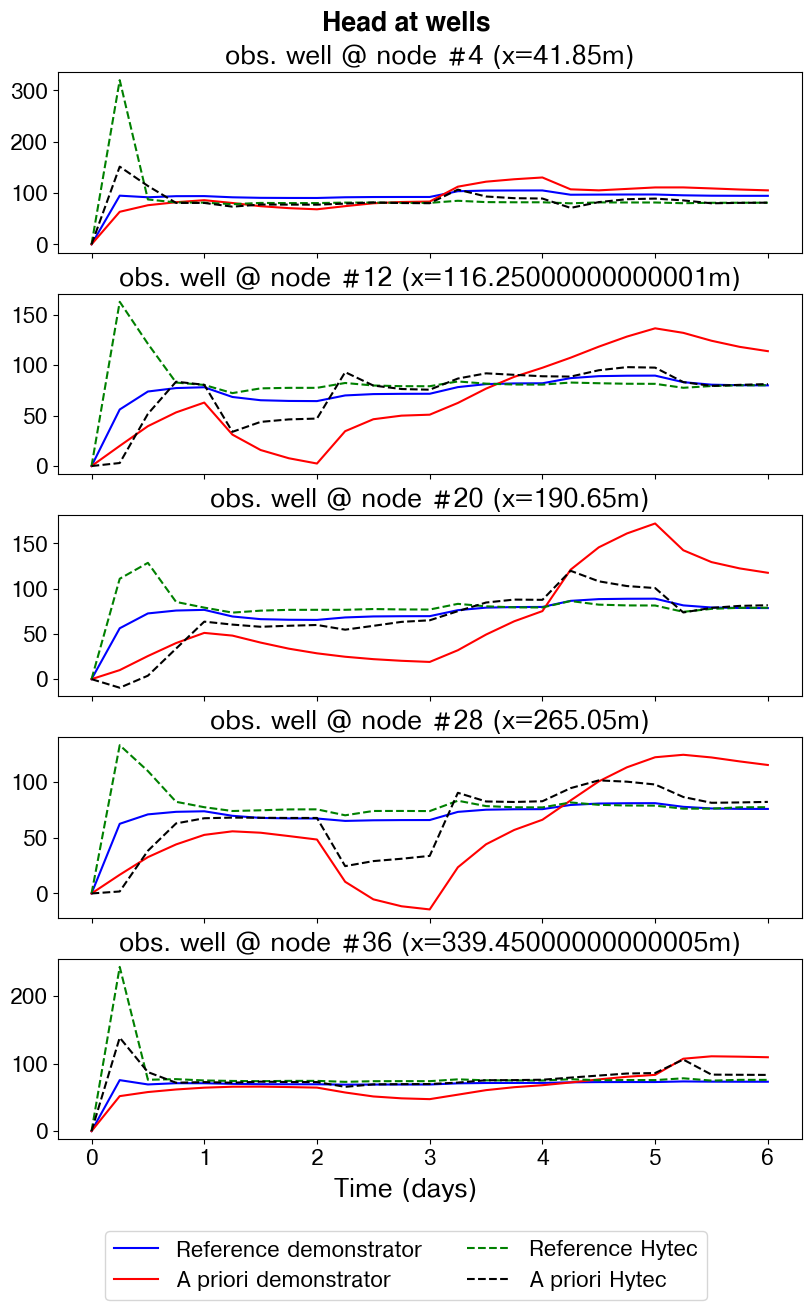

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(sorted(production_locations + injection_locations)):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        np.arange(nt + 1) * dt / 3600 / 24,
        model_reference.fl_model.head[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
    )
    ax.plot(
        np.arange(nt + 1) * dt / 3600 / 24,
        model_estimate.fl_model.head[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )
    ax.plot(
        grid_sample_times / 3600 / 24,
        head_ref_hytec[node_id, 0, 0, :],
        label="Reference Hytec",
        c="g",
        linestyle="--",
    )
    ax.plot(
        grid_sample_times / 3600 / 24,
        head_estimate_hytec[node_id, 0, 0, :],
        label="A priori Hytec",
        c="k",
        linestyle="--",
    )

plotter.fig.supxlabel("Time (days)")
plotter.fig.suptitle("Head at wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.0)

fname = "head_ref_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Animated plot
nb_frames = min(model_reference.time_params.nt, 30)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_coordinates,
            "y": head_ref_hytec[:, 0, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": head_estimate_hytec[:, 0, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Hytec",
    xlabel="X (m)",
    ylabel="Head [m]",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "True": {
            "x": x_coordinates,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Pyrtid",
    xlabel="X (m)",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(head_estimate_hytec.shape[-1] / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {grid_sample_times[ts_btw_frames * frame] / 3600:.3f} h"


for ax_name in ["ax1-1", "ax1-2"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            0.0,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            0.0,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time()),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="upper left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [ ]:
noise_std = 1.5  # This is an absolute value
rng = np.random.default_rng(2021)


def get_white_noise(shape: int) -> NDArrayFloat:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    return rng.normal(0.0, noise_std, shape)

- Check the intensity of the noise

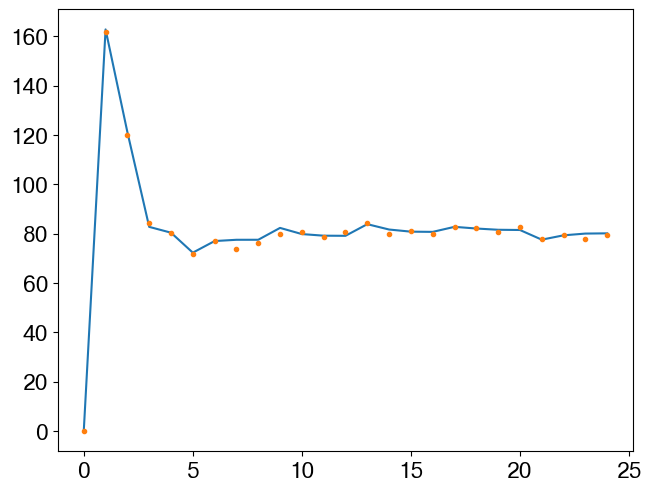

In [ ]:
# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(head_ref_hytec[node_id, 0, 0, :].shape[0])

node_id = production_locations[0]
plt.figure(facecolor="w")
plt.plot(head_ref_hytec[node_id, 0, 0, :])
plt.plot(head_ref_hytec[node_id, 0, 0, :] + obs_noise, marker=".", linestyle="none")

### Demonstrator


In [ ]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=min_val,
    ubounds=max_val,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for node_id in production_locations + injection_locations:
    vals = model_reference.fl_model.head[node_id, 0, :]
    timesteps = np.arange(vals.shape[0])

    observables[node_id] = dminv.Observable(
        state_variable=dminv.StateVariable.HEAD,
        location=(slice(node_id, node_id + 1, 1), slice(None)),
        timesteps=timesteps,
        values=vals + obs_noise[:],
        uncertainties=noise_std,
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, list(observables.values()))
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

is_grad_ok = executor.is_adjoint_gradient_correct()

In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


- Compute the first objective function

In [ ]:
executor.eval_scaled_loss(param.preconditioner(param.values), is_save_state=False)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 29206.35757249107
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 3.4239120627006277e-05
INFO:root:Loss (scaled)         = 1.0



1.0

In [ ]:
timesteps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

### HYTEC

INFO:root:The job is over ! Elapsed time = 0:00:03.529153


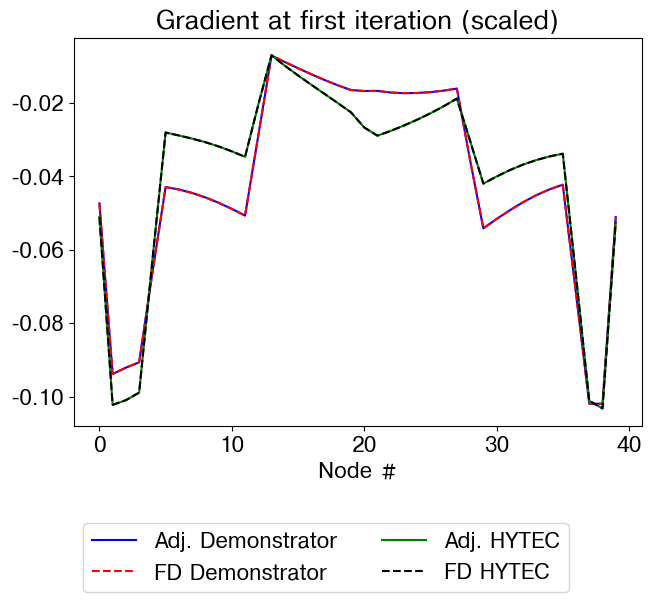

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

simu_inverse.model.get_sub_model(hymd.HydrodynamicModel).get_unique_subitem_from_type(
    hymd.FlowCrankNicolson
).value = 0.88

# 2) Add the observation wells
for count, (ix, well_type) in enumerate(
    zip(
        production_locations + injection_locations,
        ["producer", "producer", "injector", "injector", "injector"],
    )
):
    x = (ix + 0.5) * dx
    zone_name = f"{well_type}_{ix}"
    # zone = simu_inverse.model.get_sub_model(hymd.GeometryModel).get_zone(name)

    vals = pressure_ref_hytec[ix, 0, 0, :] + obs_noise

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable="pressure",
        units="Pa",
        timesteps=grid_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size) * ix,
    )
    simu_inverse.register_observable(
        zone_name, obs, obs_file_path=f"observables/{zone_name}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb", hymd.AdjointStateStatus("enabled"), hymd.FdGradientCheck("initial")
    ),
    hymd.AdjustedParameterConfig(
        "permeability",
        hymd.Lbound(min_val, units="m/s"),
        hymd.Ubound(max_val, units="m/s"),
        hymd.Preconditioner("logarithmic"),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written


# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

# HYTEC
ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

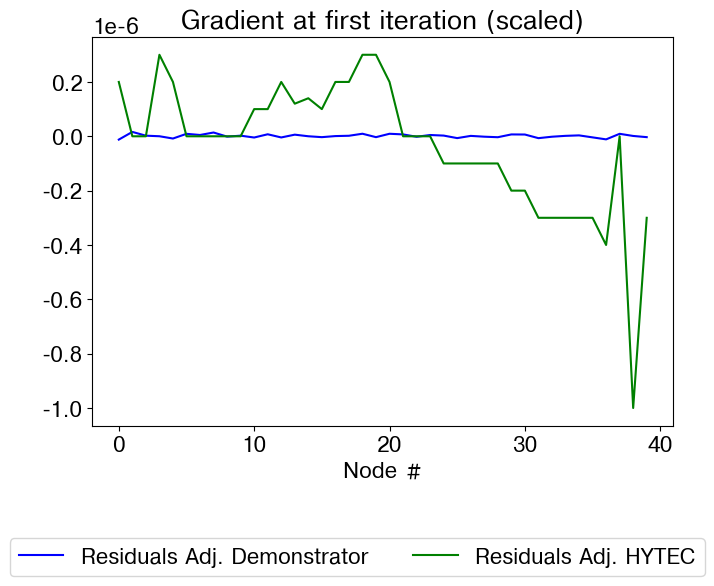

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor,
    label="Residuals Adj. Demonstrator",
    c="b",
)

# HYTEC
ax.plot(
    (hytec_adjoint_gradient["value"] - hytec_fd_gradient["value"]),
    label="Residuals Adj. HYTEC",
    c="g",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)